In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Define the model

In [2]:
class EEGGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(EEGGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(1.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        cover_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, cover_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()



## Sample from the prior

In [3]:
times = torch.linspace(1, 10, 1000)


In [4]:
times

tensor([ 1.0000,  1.0090,  1.0180,  1.0270,  1.0360,  1.0450,  1.0541,  1.0631,
         1.0721,  1.0811,  1.0901,  1.0991,  1.1081,  1.1171,  1.1261,  1.1351,
         1.1441,  1.1532,  1.1622,  1.1712,  1.1802,  1.1892,  1.1982,  1.2072,
         1.2162,  1.2252,  1.2342,  1.2432,  1.2523,  1.2613,  1.2703,  1.2793,
         1.2883,  1.2973,  1.3063,  1.3153,  1.3243,  1.3333,  1.3423,  1.3514,
         1.3604,  1.3694,  1.3784,  1.3874,  1.3964,  1.4054,  1.4144,  1.4234,
         1.4324,  1.4414,  1.4505,  1.4595,  1.4685,  1.4775,  1.4865,  1.4955,
         1.5045,  1.5135,  1.5225,  1.5315,  1.5405,  1.5495,  1.5586,  1.5676,
         1.5766,  1.5856,  1.5946,  1.6036,  1.6126,  1.6216,  1.6306,  1.6396,
         1.6486,  1.6577,  1.6667,  1.6757,  1.6847,  1.6937,  1.7027,  1.7117,
         1.7207,  1.7297,  1.7387,  1.7477,  1.7568,  1.7658,  1.7748,  1.7838,
         1.7928,  1.8018,  1.8108,  1.8198,  1.8288,  1.8378,  1.8468,  1.8559,
         1.8649,  1.8739,  1.8829,  1.89

In [7]:
model = EEGGPModel([],[], likelihood)
model

EEGGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

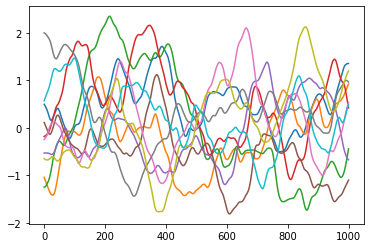

In [12]:
for i in range(10):
    plt.plot(model(times).sample())

In [13]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [17]:
train_x = times
train_y = 2*model(times).sample()


In [18]:
trained_model = EEGGPModel(train_x, train_y, likelihood)
trained_model.train()
likelihood.train()



# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.789   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.756   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.718   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 0.681   lengthscale: 0.837   noise: 0.554
Iter 5/50 - Loss: 0.639   lengthscale: 0.855   noise: 0.513
Iter 6/50 - Loss: 0.606   lengthscale: 0.851   noise: 0.474
Iter 7/50 - Loss: 0.563   lengthscale: 0.841   noise: 0.437
Iter 8/50 - Loss: 0.528   lengthscale: 0.822   noise: 0.403
Iter 9/50 - Loss: 0.494   lengthscale: 0.806   noise: 0.370
Iter 10/50 - Loss: 0.450   lengthscale: 0.790   noise: 0.340
Iter 11/50 - Loss: 0.405   lengthscale: 0.782   noise: 0.312
Iter 12/50 - Loss: 0.358   lengthscale: 0.773   noise: 0.286
Iter 13/50 - Loss: 0.315   lengthscale: 0.767   noise: 0.261
Iter 14/50 - Loss: 0.272   lengthscale: 0.764   noise: 0.239
Iter 15/50 - Loss: 0.230   lengthscale: 0.766   noise: 0.218
Iter 16/50 - Loss: 0.192   lengthscale: 0.773   noise: 0.199
Iter 17/50 - Loss: 0.144   length

In [20]:
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -5.158605575561523
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


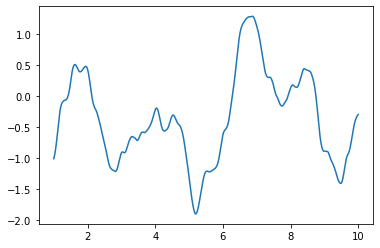

In [22]:
plt.plot(train_x, train_y)

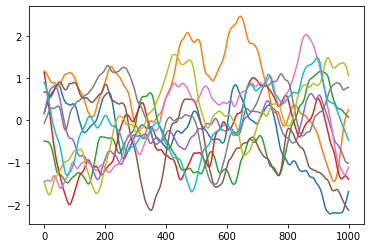

In [21]:
for i in range(10):
    plt.plot(trained_model(times).sample())
